In [46]:
import numpy as np
import matplotlib.pyplot as plt

# R3: **Single Product Pricing in Adversarial Environment**

Develop a robust pricing algorithm for a single product that works effectively against **adversarial environments** where buyer valuations can be strategically chosen to maximize the company's regret.


##  **ADVERSARIAL BUYER MODEL**

**Adversarial Buyer**: Unlike stochastic environments (R1/R2), the adversarial buyer has a **predefined sequence of valuations** that can be strategically chosen by an adversary to **maximize the company's regret**.


In [47]:
class AdversarialBuyer:
    def __init__(self, valuation_sequence):
        self.valuation_sequence = valuation_sequence
        self.t = 0
        
    def round(self, price):
        if self.t >= len(self.valuation_sequence):
            # If we've exhausted the sequence, return 0
            return 0
            
        valuation = self.valuation_sequence[self.t]
        self.t += 1
        return 1 if price < valuation else 0
    
    def reset(self):
        self.t = 0

In [48]:
def generate_adversarial_sequence(T, strategy):
    if strategy == 'oscillating':
        return np.array([0.4 if t % 3 == 0 else 0.8 for t in range(T)])
    
    elif strategy == 'delayed_reward':
        return np.concatenate([np.full(T//2, 0.2), np.full(T//2, 0.8)])
    
    elif strategy == 'random_adversarial':
        np.random.seed(42)
        return np.random.uniform(0, 1, T)
    
    elif strategy == 'custom_pattern': 
        sequence = np.zeros(T)
        for t in range(T):
            if t < T // 3:
                sequence[t] = 0.3
            elif t < 2 * T // 3:
                sequence[t] = 0.7
            else:
                sequence[t] = 0.5
        return sequence
    
    else:
        raise ValueError(f"Unknown strategy: {strategy}")

def apply_noise(sequence, sigma):
    return np.random.normal(loc=sequence, scale=sigma)

def generate_adversarial_valuations(T, strategy, sigma=0.1):
    sequence = generate_adversarial_sequence(T, strategy)
    noisy_sequence = apply_noise(sequence, sigma)
    return noisy_sequence

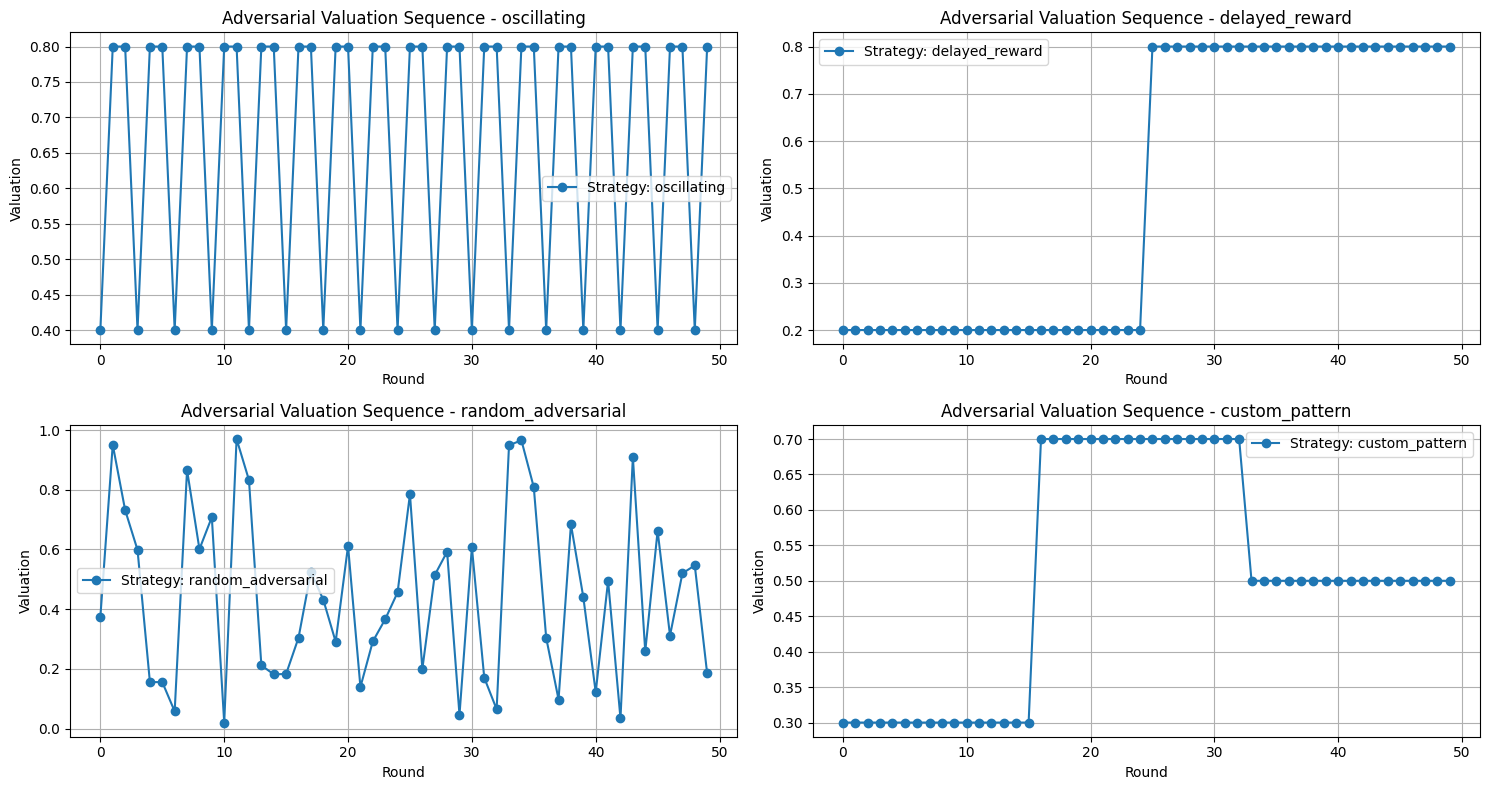

In [49]:
T_test = 50
strategies = ['oscillating', 'delayed_reward', 'random_adversarial', 'custom_pattern']

fig, axes = plt.subplots(2, 2, figsize=(15, 8))
axes = axes.flatten()

for i, strategy in enumerate(strategies):
    valuation_sequence = generate_adversarial_sequence(T_test, strategy)    
    axes[i].plot(valuation_sequence, marker='o', label=f'Strategy: {strategy}')
    axes[i].set_title(f'Adversarial Valuation Sequence - {strategy}')
    axes[i].set_xlabel('Round')
    axes[i].set_ylabel('Valuation')
    axes[i].legend()
    axes[i].grid()

plt.tight_layout()
plt.show()

In [50]:
def compute_baseline(T, P, B, evaluations):
    # initializing parameters
    rho = B / T  # cost per round
    K = len(P)  # number of prices
    f = np.zeros(K)  # expected utility for each price
    c = np.zeros(K)  # expected cost for each price 

    # for each price, compute expected profit and cost
    for pidx in range(len(P)):
        total_profit = 0
        num_sales = 0
        for t in range(T):
            if evaluations[t] >= P[pidx]:
                num_sales += 1
                total_profit += P[pidx]  
        
        # compute expected profit and cost
        f[pidx] = total_profit / T  # expected profit per round
        c[pidx] = num_sales / T     # expected probability of sale (cost rate)

    # select the highest expected utility price with expected cost less than rho
    feasible = c <= rho
    if np.any(feasible):
        best_idx = np.argmax(f * feasible)
    else:
        print("\nNo feasible price found under the budget constraint.")
    return float(P[best_idx]), float(f[best_idx]), float(c[best_idx])

In [51]:
class EXP3Agent:
    def __init__(self, K, learning_rate=0.1):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate*l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

In [52]:
class Company:
    def __init__(self, K, B, T, learning_rate=0.5):
        self.K = K # number of prices
        self.B = B # budget
        self.T = T # number of rounds
        self.t = 0 # round index
        self.P = np.linspace(0, 1, 11) # prices
        self.p_idx = 0 # current price index
        self.rho = B / T  # cost per round
        self.agent = EXP3Agent(K) # regret minimizer
        self.lmbd = 0.0 # lambda for the regret minimizer
        self.learning_rate = learning_rate # learning rate for the regret minimizer
        self.N_pulls = np.zeros(K) # number of pulls for each price
    
    def pull_arm(self):
        if self.B < 1:
            self.p_idx = 0
            return 0
        self.p_idx = self.agent.pull_arm()
        return self.p_idx
    
    def update(self, f_t, c_t):

        # update regret minimizer
        L = f_t - self.lmbd*(c_t - self.rho)
        L_up = 1 -(1/self.rho)*(-self.rho)
        L_low = 0 -(1/self.rho)*(1-self.rho)
        rescaled_L = (L - L_low)/(L_up-L_low)
        self.agent.update(1 -rescaled_L) # we need to maximize L

        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.learning_rate*(self.rho-c_t), a_min=0, a_max=1/self.rho)

        # update budget
        self.B -= c_t

        # log
        self.N_pulls[self.p_idx] += 1

In [53]:
class Company2:
    def __init__(self, valuation, B, K, T, eta):
        self.P = np.linspace(0, 1, K)  # prices
        self.K = K
        self.valuation = valuation
        self.B = B
        self.eta = eta
        self.T = T
        self.rho = self.B/self.T
        self.lmbd = 1
        self.t = 0

    def pull_arm(self):
        if self.B < 1:
            return 0
        val= self.valuation/(self.lmbd+1)
        index = np.abs(self.P - val).argmin()
        return index

    def update(self, f_t, c_t):
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        self.B -= c_t

In [54]:
T = 10000
B = 5000
P = np.linspace(0, 1, 11)
K = len(P)

evaluations = generate_adversarial_valuations(T, 'oscillating')
best_price, exp_utility, exp_cost = compute_baseline(T, P, B, evaluations)

print("best_price:", best_price)
print("expected utility:", exp_utility)
print("expected cost:", exp_cost)

n_trials = 5

regret_per_trial = []

for seed in range(n_trials):
  np.random.seed(seed)

  # Create adversarial buyer with the predefined sequence
  buyer = AdversarialBuyer(evaluations)
  #agent = Company2(valuation=0.0, B=B, K=K, T=T, eta=0.1)
  agent = Company(K=K, B=B, T=T, learning_rate=0.4)
  ag_utility = np.zeros(T)

  flag = True
  for i in range(T):
    arm = agent.pull_arm()
    price = P[arm]

    sold = buyer.round(price)

    f_t = price if sold else 0        # reward: revenue
    c_t = 1 if sold else 0            # cost: unit consumed

    agent.update(f_t=f_t, c_t=c_t)

    ag_utility[i] = f_t

    if agent.B <= 0 and flag:
      print("TRIAL", seed , "Budget exhausted at round", i)
      flag = False

  # Reset buyer for next trial
  buyer.reset()
  
  cumulative_regret = np.cumsum(exp_utility-ag_utility)
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_std = regret_per_trial.std(axis=0)

print("Agent Cumulative Reward", np.sum(ag_utility))
print("Average cumulative regret", average_regret[-1])

best_price: 0.8
expected utility: 0.26864000000000626
expected cost: 0.3358
Agent Cumulative Reward 2404.0
Average cumulative regret 266.3000000000531


In [55]:
agent.N_pulls

array([ 246.,  212.,  482.,  238.,  458., 1114., 1011., 1185., 2412.,
       1320., 1322.])

##  **COMPANY STRATEGY: EXP3 Algorithm**

**EXP3**  where no distributional assumptions can be made.


In [56]:
class CompanyEXP3:
  def __init__(self, K, B, T):
    """
    EXP3 algorithm adapted for adversarial bandits with budget constraints.
    
    :param K: Number of arms (prices)
    :param B: Total budget
    :param T: Time horizon
    :param gamma: Exploration parameter (if None, uses theoretical optimal)
    :param eta: Learning rate (if None, uses theoretical optimal)
    """
    self.K = K
    self.T = T
    self.budget = B
    self.initial_budget = B
    self.rho = B / T  # Budget rate
    self.t = 0
    self.p_t = None
    
    self.gamma = min(1, np.sqrt(K * np.log(K) / ((np.e - 1) * T)))
    self.eta = np.sqrt(np.log(K) / (K * T))
    
    # Initialize weights and estimated rewards
    self.weights = np.ones(K)
    self.estimated_rewards = np.zeros(K)
    self.estimated_costs = np.zeros(K)
    self.probabilities = np.ones(K) / K
    
    print(f"EXP3 initialized with γ={self.gamma:.4f}, η={self.eta:.4f}")

  def pull_arm(self):
    """
    Select an arm using EXP3 with budget-aware probability distribution.
    """
    if self.budget < 1:
      self.p_t = 0  # Default to lowest price when budget exhausted
      return 0
    
    # Compute EXP3 probabilities
    # EXP3 probability update
    exp_weights = np.exp(self.eta * self.estimated_rewards)
    self.weights = exp_weights
    # Normalize to get probabilities with exploration
    sum_weights = np.sum(self.weights)
    self.probabilities = (1 - self.gamma) * (self.weights / sum_weights) + self.gamma / self.K
    
    # Budget-aware arm selection using linear programming approach
    # similar to UCB but with EXP3 probabilities as baseline
    if self.t > 0:
      gamma_budget = self._compute_budget_aware_distribution()
      self.p_t = np.random.choice(self.K, p=gamma_budget)
    else:
      self.p_t = np.random.choice(self.K, p=self.probabilities)
    
    return self.p_t


  def _compute_budget_aware_distribution(self):
    """
    Compute budget-aware probability distribution combining EXP3 with budget constraints.
    """
    # Remaining budget rate
    remaining_rounds = max(1, self.T - self.t)
    current_rho = self.budget / remaining_rounds
    
    # If we have plenty of budget, use pure EXP3
    if current_rho >= self.rho:
      return self.probabilities
    
    # Otherwise, solve constrained optimization similar to UCB approach
    # but using EXP3 probabilities as the objective
    try:
      # Objective: maximize expected utility weighted by EXP3 probabilities
      # We approximate this by using estimated rewards
      c = -self.estimated_rewards  # Negative for maximization
      
      # Budget constraint: expected cost <= current budget rate
      A_ub = [self.estimated_costs]
      b_ub = [current_rho]
      
      # Probability constraint
      A_eq = [np.ones(self.K)]
      b_eq = [1]
      
      bounds = [(0, 1)] * self.K
      
      res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, 
                           bounds=bounds, method='highs')
      
      if res.success:
        # Blend with EXP3 probabilities for exploration
        blend_factor = 0.7  # How much to trust the LP solution
        gamma_budget = blend_factor * res.x + (1 - blend_factor) * self.probabilities
        return gamma_budget / np.sum(gamma_budget)  # Renormalize
      else:
        return self.probabilities
    except:
      # Fallback to EXP3 probabilities if optimization fails
      return self.probabilities

  def update(self, f_t, c_t):
    """
    Update the algorithm with observed reward and cost.
    
    :param f_t: Observed reward (revenue)
    :param c_t: Observed cost (units sold)
    """
    self.t += 1
    self.budget -= c_t
    
    # EXP3 importance-weighted reward estimation
    if self.probabilities[self.p_t] > 0:
      # Importance-weighted estimator
      reward_estimate = f_t / self.probabilities[self.p_t]
      cost_estimate = c_t / self.probabilities[self.p_t]
      
      # Update estimated rewards for the selected arm
      self.estimated_rewards[self.p_t] += reward_estimate
      self.estimated_costs[self.p_t] = (self.estimated_costs[self.p_t] * (self.t - 1) + cost_estimate) / self.t
    
    # Clip estimates to prevent explosion
    self.estimated_rewards = np.clip(self.estimated_rewards, -10, 10)
    self.estimated_costs = np.clip(self.estimated_costs, 0, 2)

  def get_algorithm_state(self):
    """Return current state for debugging/analysis."""
    return {
      'weights': self.weights.copy(),
      'probabilities': self.probabilities.copy(),
      'estimated_rewards': self.estimated_rewards.copy(),
      'estimated_costs': self.estimated_costs.copy(),
      'budget': self.budget,
      'round': self.t
    }

## SIMULATION

In [57]:
def compute_best_price_adversarial(prices, rho, valuation_sequence):
    """
    Compute optimal randomized pricing strategy for adversarial environment.
    For adversarial environment, we compute the theoretical benchmark against
    the valuation sequence.
    
    Parameters:
    - prices: list or array of possible prices
    - rho: budget constraint (B/T)
    - valuation_sequence: adversarial valuation sequence
    
    Returns:
    - gamma: optimal price distribution 
    - expected_revenue: expected revenue under strategy
    - expected_units_sold: expected units sold under strategy
    """
    prices = np.array(prices)
    T = len(valuation_sequence)
    
    # For each price, compute win probability against adversarial sequence
    win_probabilities = np.zeros(len(prices))
    for i, price in enumerate(prices):
        win_probabilities[i] = np.mean(valuation_sequence > price)
    
    print(f"Win probabilities against adversarial sequence: {win_probabilities}")
    
    # If no constraint is binding, choose best price
    revenues = prices * win_probabilities
    if np.max(win_probabilities) <= rho:
        gamma = np.zeros(len(prices))
        gamma[np.argmax(revenues)] = 1.0
        return gamma, np.max(revenues), np.max(win_probabilities)
    
    # Solve linear program for constrained case
    c = -revenues  # Negate for minimization
    
    # Constraint: expected units sold ≤ rho
    A_ub = [win_probabilities]
    b_ub = [rho]
    
    # Constraint: gamma is a probability distribution
    A_eq = [np.ones(len(prices))]
    b_eq = [1]
    
    bounds = [(0, 1)] * len(prices)
    
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub,
                           A_eq=A_eq, b_eq=b_eq,
                           bounds=bounds, method='highs')
    
    if res.success:
        gamma = res.x
        expected_revenue = -res.fun
        expected_units_sold = np.sum(gamma * win_probabilities)
        return gamma, expected_revenue, expected_units_sold
    else:
        # Fallback: choose best unconstrained price
        gamma = np.zeros(len(prices))
        gamma[np.argmax(revenues)] = 1.0
        return gamma, np.max(revenues), win_probabilities[np.argmax(revenues)]

In [58]:
def compute_best_price_adversarial_2(prices, rho, valuation_sequence):
    """
    Run each price through the adversarial buyer and compute the expected revenue
    considering the budget constraint.

    Parameters:
    - prices: list or array of possible prices
    - rho: budget constraint (B/T) - maximum units that can be sold per round
    - valuation_sequence: adversarial valuation sequence
    
    Returns:
    - best_price: the optimal price to use
    - max_revenue: maximum expected revenue achievable
    - optimal_gamma: optimal price distribution
    """
    prices = np.array(prices)
    T = len(valuation_sequence)
    
    # For each price, compute the win probability against the adversarial sequence
    win_probabilities = np.zeros(len(prices))
    expected_revenues = np.zeros(len(prices))
    
    for i, price in enumerate(prices):
        # Count how many times this price would result in a sale
        wins = np.sum(valuation_sequence > price)
        win_probabilities[i] = wins / T
        expected_revenues[i] = price * win_probabilities[i]
    
    print(f"Prices: {prices}")
    print(f"Win probabilities: {win_probabilities}")
    print(f"Expected revenues: {expected_revenues}")
    
    # Check if budget constraint is binding
    max_win_prob = np.max(win_probabilities)
    
    if max_win_prob <= rho:
        # Budget constraint is not binding, choose price with highest revenue
        best_idx = np.argmax(expected_revenues)
        best_price = prices[best_idx]
        max_revenue = expected_revenues[best_idx]
        
        # Create gamma distribution (put all probability on best price)
        gamma = np.zeros(len(prices))
        gamma[best_idx] = 1.0
        
        print(f"Budget constraint not binding. Best price: {best_price}, Revenue: {max_revenue}")
        return best_price, max_revenue, gamma
    
    else:
        # Budget constraint is binding, solve constrained optimization
        print(f"Budget constraint binding (rho={rho}, max_win_prob={max_win_prob})")
        
        # Solve linear program to find optimal mixed strategy
        c = -expected_revenues  # Negate for minimization (linprog minimizes)
        
        # Constraint: expected units sold ≤ rho
        A_ub = [win_probabilities]
        b_ub = [rho]
        
        # Constraint: gamma is a probability distribution
        A_eq = [np.ones(len(prices))]
        b_eq = [1]
        
        bounds = [(0, 1)] * len(prices)
        
        try:
            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub,
                                   A_eq=A_eq, b_eq=b_eq,
                                   bounds=bounds, method='highs')
            
            if res.success:
                gamma = res.x
                max_revenue = -res.fun  # Convert back from minimization
                
                # Find the "representative" best price (weighted average or most probable)
                best_price = np.average(prices, weights=gamma)
                
                print(f"Optimal mixed strategy found:")
                print(f"Gamma distribution: {gamma}")
                print(f"Expected revenue: {max_revenue}")
                print(f"Weighted average price: {best_price}")
                
                return best_price, max_revenue, gamma
            else:
                print("Linear programming failed, falling back to unconstrained optimum")
                
        except Exception as e:
            print(f"Optimization error: {e}, falling back to unconstrained optimum")
        
        # Fallback: choose best unconstrained price
        best_idx = np.argmax(expected_revenues)
        best_price = prices[best_idx]
        max_revenue = expected_revenues[best_idx]
        
        gamma = np.zeros(len(prices))
        gamma[best_idx] = 1.0
        
        return best_price, max_revenue, gamma

In [59]:
T = 10000
B = 6000
P = np.linspace(0, 1, 11)
K = len(P)

# Generate adversarial valuation sequence
adversarial_strategy = 'oscillating'  # Can be changed to test different strategies
valuation_sequence = generate_adversarial_sequence(T, adversarial_strategy)

# Compute optimal benchmark against this adversarial sequence
gamma, exp_utility, expected_units_sold = compute_best_price_adversarial_2(P, B/T, valuation_sequence)
print(f"Adversarial strategy: {adversarial_strategy}")
print(f"Gamma: {gamma}")
print(f"Expected utility: {exp_utility}")
print(f"Expected unit sold: {expected_units_sold}")

n_trials = 10

regret_per_trial = []

for seed in range(n_trials):
  np.random.seed(seed)

  # Create adversarial buyer with the predefined sequence
  buyer = AdversarialBuyer(valuation_sequence)
  agent = CompanyEXP3(K=K, B=B, T=T)
  ag_utility = np.zeros(T)

  flag = True
  for i in range(T):
    arm = agent.pull_arm()
    price = P[arm]

    sold = buyer.round(price)

    f_t = price if sold else 0        # reward: revenue
    c_t = 1 if sold else 0            # cost: unit consumed

    agent.update(f_t=f_t, c_t=c_t)

    ag_utility[i] = f_t

    if agent.budget <= 0 and flag:
      print("TRIAL", seed , "Budget exhausted at round", i)
      flag = False

  # Reset buyer for next trial
  buyer.reset()
  
  cumulative_regret = np.cumsum(exp_utility-ag_utility)
  regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_std = regret_per_trial.std(axis=0)

print("Agent Cumulative Reward", np.sum(ag_utility))
print("Average cumulative regret", average_regret[-1])

Prices: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
Win probabilities: [1.     1.     1.     1.     0.6666 0.6666 0.6666 0.6666 0.     0.
 0.    ]
Expected revenues: [0.      0.1     0.2     0.3     0.26664 0.3333  0.39996 0.46662 0.
 0.      0.     ]
Budget constraint binding (rho=0.6, max_win_prob=1.0)
Optimization error: name 'optimize' is not defined, falling back to unconstrained optimum
Adversarial strategy: oscillating
Gamma: 0.7000000000000001
Expected utility: 0.46662000000000003
Expected unit sold: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
EXP3 initialized with γ=0.0392, η=0.0047
TRIAL 0 Budget exhausted at round 9728
EXP3 initialized with γ=0.0392, η=0.0047
TRIAL 1 Budget exhausted at round 9715
EXP3 initialized with γ=0.0392, η=0.0047
TRIAL 2 Budget exhausted at round 9652
EXP3 initialized with γ=0.0392, η=0.0047
TRIAL 3 Budget exhausted at round 9761
EXP3 initialized with γ=0.0392, η=0.0047
TRIAL 4 Budget exhausted at round 9718
EXP3 initialized with γ=0.0392, η=0.0047
TRIAL 5 

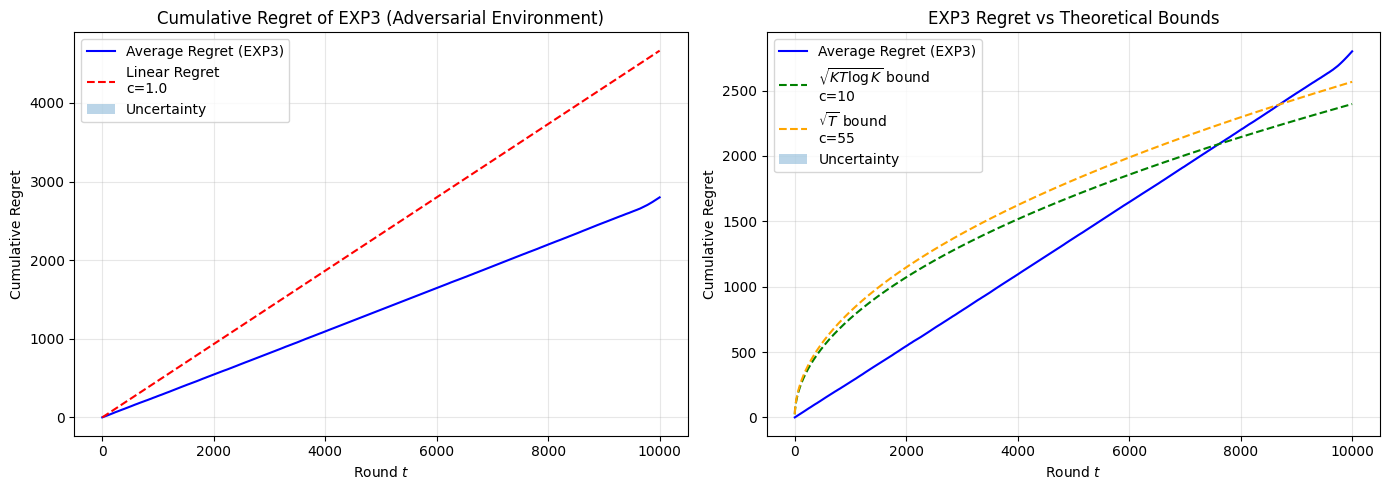

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# First subplot: Cumulative regret with linear line 
axs[0].plot(np.arange(T), average_regret, label='Average Regret (EXP3)', color='blue')
axs[0].set_title('Cumulative Regret of EXP3 (Adversarial Environment)')

c_linear = 1.0
linear_regret = np.arange(T) * exp_utility * c_linear # Linear regret line
axs[0].plot(np.arange(T), linear_regret, label=f'Linear Regret\nc={c_linear}', linestyle='--', color='red')
axs[0].fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)
axs[0].set_xlabel('Round $t$')
axs[0].set_ylabel('Cumulative Regret')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# Second subplot: EXP3 theoretical bounds
axs[1].plot(np.arange(T), average_regret, label='Average Regret (EXP3)', color='blue')
axs[1].set_title('EXP3 Regret vs Theoretical Bounds')

t_vals = np.arange(1, T+1)

# EXP3 theoretical bound: O(sqrt(KT log K))
c_exp3 = 10
exp3_bound = np.sqrt(K * t_vals * np.log(K)) * exp_utility * c_exp3
axs[1].plot(np.arange(T), exp3_bound, label=f'$\\sqrt{{KT\\log K}}$ bound\nc={c_exp3}', linestyle='--', color='green')

# Simpler sqrt(T) bound for comparison
c_sqrt = 55
sqrt_bound = np.sqrt(t_vals) * exp_utility * c_sqrt
axs[1].plot(np.arange(T), sqrt_bound, label=f'$\\sqrt{{T}}$ bound\nc={c_sqrt}', linestyle='--', color='orange')

# Fill between for uncertainty in the second plot
axs[1].fill_between(
    np.arange(T),
    average_regret - regret_std / np.sqrt(n_trials),
    average_regret + regret_std / np.sqrt(n_trials),
    alpha=0.3,
    label='Uncertainty'
)

# Set labels and legends for the second subplot
axs[1].set_xlabel('Round $t$')
axs[1].set_ylabel('Cumulative Regret')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()